In [26]:
import pandas as pd
import numpy as np
import json
from sklearn.utils import shuffle

In [12]:
file = open("F:\Code\HUST\Vietnamese-text-classification\content.json", encoding = 'utf8')

In [13]:
data = json.load(file)

In [15]:
df = pd.DataFrame(data)

In [16]:
df.head()

,id,author,content,crawled_at,picture_count,processed,source,title,topic,url,category
0,2,Lâm Thỏa,"*Việt Nam - Malaysia: 20h thứ Tư 8/6, trên VnE...",2022-06-07 14:05:51.433712,2,0,None,HLV Malaysia dọa ngáng đường Việt Nam,Thể thao,https://vnexpress.net/hlv-malaysia-doa-ngang-d...,0
1,3,Thanh Tâm,"""Các khu dân cư của thành phố Severodonetsk đã...",2022-06-07 14:05:51.797545,2,0,None,Nga tuyên bố 'giải phóng' hoàn toàn khu dân cư...,Thế giới,https://vnexpress.net/nga-tuyen-bo-giai-phong-...,1
2,4,Thảo Mi,"Ngày 7/6, phiên xử phúc thẩm ông Tất Thành Can...",2022-06-07 14:05:53.482540,2,0,None,Ông Tất Thành Cang được đề nghị giảm án,Pháp luật,https://vnexpress.net/ong-tat-thanh-cang-duoc-...,1
3,5,Quốc Thắng,"Chiều 7/6, Khoa bị Công an quận Phú Nhuận phối...",2022-06-07 14:05:53.848085,2,0,None,Nghi can sát hại cha bị bắt,Pháp luật,https://vnexpress.net/nghi-can-sat-hai-cha-bi-...,1
4,6,Vũ Hoàng,"Thủ tướng Anh Boris Johnson hôm 6/6 đã ""thoát ...",2022-06-07 14:05:54.226303,1,0,None,Sóng gió chờ đón Thủ tướng Anh hậu bỏ phiếu bấ...,Thế giới,https://vnexpress.net/thoat-hiem-bat-tin-nhiem...,1


In [27]:
print(df.shape)
df = shuffle(df)

(19411, 6)


In [20]:
columns = ['id', 'crawled_at', 'processed', 'source', 'topic']
df = df.drop(columns=columns)

In [21]:
print(df.shape)

(19411, 6)


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19411 entries, 0 to 19410
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   author         19411 non-null  object
 1   content        19411 non-null  object
 2   picture_count  19411 non-null  int64 
 3   title          19411 non-null  object
 4   url            19411 non-null  object
 5   category       19411 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 910.0+ KB


In [37]:
content_array = np.array(df['content'])

In [38]:
import re
import nltk

In [44]:
corpus = []

for i in range(0, 19410):
    newArr = re.sub('/([\u0041-\u005A\u0061-\u007A\u00AA\u00B5\u00BA\u00C0-\u00D6\u00D8-\u00F6\u00F8-\u02C1\u02C6-\u02D1\u02E0-\u02E4\u02EC\u02EE\u0370-\u0374\u0376\u0377\u037A-\u037D\u0386\u0388-\u038A\u038C\u038E-\u03A1\u03A3-\u03F5\u03F7-\u0481\u048A-\u0527\u0531-\u0556\u0559\u0561-\u0587\u05D0-\u05EA\u05F0-\u05F2\u0620-\u064A\u066E\u066F\u0671-\u06D3\u06D5\u06E5\u06E6\u06EE\u06EF\u06FA-\u06FC\u06FF\u0710\u0712-\u072F\u074D-\u07A5\u07B1\u07CA-\u07EA\u07F4\u07F5\u07FA\u0800-\u0815\u081A\u0824\u0828\u0840-\u0858\u08A0\u08A2-\u08AC\u0904-\u0939\u093D\u0950\u0958-\u0961\u0971-\u0977\u0979-\u097F\u0985-\u098C\u098F\u0990\u0993-\u09A8\u09AA-\u09B0\u09B2\u09B6-\u09B9\u09BD\u09CE\u09DC\u09DD\u09DF-\u09E1\u09F0\u09F1\u0A05-\u0A0A\u0A0F\u0A10\u0A13-\u0A28\u0A2A-\u0A30\u0A32\u0A33\u0A35\u0A36\u0A38\u0A39\u0A59-\u0A5C\u0A5E\u0A72-\u0A74\u0A85-\u0A8D\u0A8F-\u0A91\u0A93-\u0AA8\u0AAA-\u0AB0\u0AB2\u0AB3\u0AB5-\u0AB9\u0ABD\u0AD0\u0AE0\u0AE1\u0B05-\u0B0C\u0B0F\u0B10\u0B13-\u0B28\u0B2A-\u0B30\u0B32\u0B33\u0B35-\u0B39\u0B3D\u0B5C\u0B5D\u0B5F-\u0B61\u0B71\u0B83\u0B85-\u0B8A\u0B8E-\u0B90\u0B92-\u0B95\u0B99\u0B9A\u0B9C\u0B9E\u0B9F\u0BA3\u0BA4\u0BA8-\u0BAA\u0BAE-\u0BB9\u0BD0\u0C05-\u0C0C\u0C0E-\u0C10\u0C12-\u0C28\u0C2A-\u0C33\u0C35-\u0C39\u0C3D\u0C58\u0C59\u0C60\u0C61\u0C85-\u0C8C\u0C8E-\u0C90\u0C92-\u0CA8\u0CAA-\u0CB3\u0CB5-\u0CB9\u0CBD\u0CDE\u0CE0\u0CE1\u0CF1\u0CF2\u0D05-\u0D0C\u0D0E-\u0D10\u0D12-\u0D3A\u0D3D\u0D4E\u0D60\u0D61\u0D7A-\u0D7F\u0D85-\u0D96\u0D9A-\u0DB1\u0DB3-\u0DBB\u0DBD\u0DC0-\u0DC6\u0E01-\u0E30\u0E32\u0E33\u0E40-\u0E46\u0E81\u0E82\u0E84\u0E87\u0E88\u0E8A\u0E8D\u0E94-\u0E97\u0E99-\u0E9F\u0EA1-\u0EA3\u0EA5\u0EA7\u0EAA\u0EAB\u0EAD-\u0EB0\u0EB2\u0EB3\u0EBD\u0EC0-\u0EC4\u0EC6\u0EDC-\u0EDF\u0F00\u0F40-\u0F47\u0F49-\u0F6C\u0F88-\u0F8C\u1000-\u102A\u103F\u1050-\u1055\u105A-\u105D\u1061\u1065\u1066\u106E-\u1070\u1075-\u1081\u108E\u10A0-\u10C5\u10C7\u10CD\u10D0-\u10FA\u10FC-\u1248\u124A-\u124D\u1250-\u1256\u1258\u125A-\u125D\u1260-\u1288\u128A-\u128D\u1290-\u12B0\u12B2-\u12B5\u12B8-\u12BE\u12C0\u12C2-\u12C5\u12C8-\u12D6\u12D8-\u1310\u1312-\u1315\u1318-\u135A\u1380-\u138F\u13A0-\u13F4\u1401-\u166C\u166F-\u167F\u1681-\u169A\u16A0-\u16EA\u1700-\u170C\u170E-\u1711\u1720-\u1731\u1740-\u1751\u1760-\u176C\u176E-\u1770\u1780-\u17B3\u17D7\u17DC\u1820-\u1877\u1880-\u18A8\u18AA\u18B0-\u18F5\u1900-\u191C\u1950-\u196D\u1970-\u1974\u1980-\u19AB\u19C1-\u19C7\u1A00-\u1A16\u1A20-\u1A54\u1AA7\u1B05-\u1B33\u1B45-\u1B4B\u1B83-\u1BA0\u1BAE\u1BAF\u1BBA-\u1BE5\u1C00-\u1C23\u1C4D-\u1C4F\u1C5A-\u1C7D\u1CE9-\u1CEC\u1CEE-\u1CF1\u1CF5\u1CF6\u1D00-\u1DBF\u1E00-\u1F15\u1F18-\u1F1D\u1F20-\u1F45\u1F48-\u1F4D\u1F50-\u1F57\u1F59\u1F5B\u1F5D\u1F5F-\u1F7D\u1F80-\u1FB4\u1FB6-\u1FBC\u1FBE\u1FC2-\u1FC4\u1FC6-\u1FCC\u1FD0-\u1FD3\u1FD6-\u1FDB\u1FE0-\u1FEC\u1FF2-\u1FF4\u1FF6-\u1FFC\u2071\u207F\u2090-\u209C\u2102\u2107\u210A-\u2113\u2115\u2119-\u211D\u2124\u2126\u2128\u212A-\u212D\u212F-\u2139\u213C-\u213F\u2145-\u2149\u214E\u2183\u2184\u2C00-\u2C2E\u2C30-\u2C5E\u2C60-\u2CE4\u2CEB-\u2CEE\u2CF2\u2CF3\u2D00-\u2D25\u2D27\u2D2D\u2D30-\u2D67\u2D6F\u2D80-\u2D96\u2DA0-\u2DA6\u2DA8-\u2DAE\u2DB0-\u2DB6\u2DB8-\u2DBE\u2DC0-\u2DC6\u2DC8-\u2DCE\u2DD0-\u2DD6\u2DD8-\u2DDE\u2E2F\u3005\u3006\u3031-\u3035\u303B\u303C\u3041-\u3096\u309D-\u309F\u30A1-\u30FA\u30FC-\u30FF\u3105-\u312D\u3131-\u318E\u31A0-\u31BA\u31F0-\u31FF\u3400-\u4DB5\u4E00-\u9FCC\uA000-\uA48C\uA4D0-\uA4FD\uA500-\uA60C\uA610-\uA61F\uA62A\uA62B\uA640-\uA66E\uA67F-\uA697\uA6A0-\uA6E5\uA717-\uA71F\uA722-\uA788\uA78B-\uA78E\uA790-\uA793\uA7A0-\uA7AA\uA7F8-\uA801\uA803-\uA805\uA807-\uA80A\uA80C-\uA822\uA840-\uA873\uA882-\uA8B3\uA8F2-\uA8F7\uA8FB\uA90A-\uA925\uA930-\uA946\uA960-\uA97C\uA984-\uA9B2\uA9CF\uAA00-\uAA28\uAA40-\uAA42\uAA44-\uAA4B\uAA60-\uAA76\uAA7A\uAA80-\uAAAF\uAAB1\uAAB5\uAAB6\uAAB9-\uAABD\uAAC0\uAAC2\uAADB-\uAADD\uAAE0-\uAAEA\uAAF2-\uAAF4\uAB01-\uAB06\uAB09-\uAB0E\uAB11-\uAB16\uAB20-\uAB26\uAB28-\uAB2E\uABC0-\uABE2\uAC00-\uD7A3\uD7B0-\uD7C6\uD7CB-\uD7FB\uF900-\uFA6D\uFA70-\uFAD9\uFB00-\uFB06\uFB13-\uFB17\uFB1D\uFB1F-\uFB28\uFB2A-\uFB36\uFB38-\uFB3C\uFB3E\uFB40\uFB41\uFB43\uFB44\uFB46-\uFBB1\uFBD3-\uFD3D\uFD50-\uFD8F\uFD92-\uFDC7\uFDF0-\uFDFB\uFE70-\uFE74\uFE76-\uFEFC\uFF21-\uFF3A\uFF41-\uFF5A\uFF66-\uFFBE\uFFC2-\uFFC7\uFFCA-\uFFCF\uFFD2-\uFFD7\uFFDA-\uFFDC]+)/g', ' ', content_array[i])
    newArr.lower()
    newArr = newArr.split()
    newArr = ' '.join(newArr)
    corpus.append(newArr)
    

In [45]:
corpus

['Bước chân vào showbiz từ năm 16 tuổi với vai trò ca sĩ của một nhóm hát nhỏ, Minh Hằng từng bước thử sức qua nhiều lĩnh vực khác nhau như người mẫu, diễn viên, tham gia các gameshow truyền hình… Đi lên từ gia cảnh khó khăn, sau nhiều năm hoạt động nghệ thuật chăm chỉ, nữ ca sĩ sinh năm 1987 đã sở hữu cho mình một khối tài sản kếch xù, giàu có mà bất kì một nghệ sĩ trẻ nào cũng ao ước. Ngoài biệt thự, căn hộ cao cấp, Minh Hằng còn sở hữu những chiếc xế hộp khủng. Từ khi bước chân vào hoạt động showbiz, Minh Hằng hiện đang có tổng cộng 3 chiếc xế hộp, tổng giá trị lên đến 14 tỷ đồng. Bên cạnh đó, Minh Hằng còn là một tín đồ hàng hiệu. Cô sở hữu nhiều món đồ đồng hồ, nhẫn kim cương tiền tỷ, túi xách, đồ hiêu đến từ các thương hiệu nổi tiếng như Hermes, Chanel hay Dior... Gần 20 năm trong nghề, Minh Hằng hiện tại là ngôi sao hạng A được trả cát-sê cao ngất ngưởng. Nữ ca sĩ xinh đẹp đã đút túi vài tỷ đồng chỉ cho việc ngồi "ghế nóng" chương trình The Face Vietnam. Cô cũng từng cầm trịch 2

In [48]:
df.columns

Index(['author', 'content', 'picture_count', 'title', 'url', 'category'], dtype='object')

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

countv = CountVectorizer(max_features = 1500)
X = countv.fit_transform(corpus).toarray()
y = df.iloc[0:19410, 5].values

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [51]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [52]:
print(X_test.shape)

(3882, 1500)


In [53]:
print(X_test)

[[0 1 0 ... 2 0 0]
 [0 1 0 ... 5 0 6]
 [0 0 0 ... 0 0 0]
 ...
 [3 0 0 ... 0 0 0]
 [1 3 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]]


In [54]:
y_pred = classifier.predict(X_test)

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [56]:
print(cm)

[[1641  318]
 [ 250 1673]]


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1959
           1       0.84      0.87      0.85      1923

    accuracy                           0.85      3882
   macro avg       0.85      0.85      0.85      3882
weighted avg       0.85      0.85      0.85      3882



In [58]:
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))

Accuracy: 85.37


In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

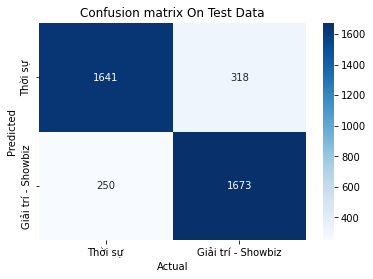

In [61]:
new_cm = pd.DataFrame(cm , index = ['Thời sự','Giải trí - Showbiz'] , columns = ['Thời sự','Giải trí - Showbiz'])
sns.heatmap(new_cm,cmap= 'Blues', annot = True, fmt='',xticklabels = ['Thời sự','Giải trí - Showbiz'], yticklabels = ['Thời sự','Giải trí - Showbiz'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix On Test Data')
plt.show()